In [65]:
using Turing
using Distances
using PyPlot
using Random
using LinearAlgebra
using LimberJack
using Interpolations

discourse.julialang.org/t/is-there-a-turing-alternative-to-pm-deterministic-from-pymc3/38667

https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/GP-Latent.html

In [66]:
# Squared-exponential covariance function
sqexp_cov_fn(D, mu, phi) = @.(mu * exp(-D^2 / (2*phi))) + 0.005 * LinearAlgebra.I
# Exponential covariance function
exp_cov_fn(D, mu, phi) = @.(mu * exp(-D / phi)) + 0.005 * LinearAlgebra.I

exp_cov_fn (generic function with 1 method)

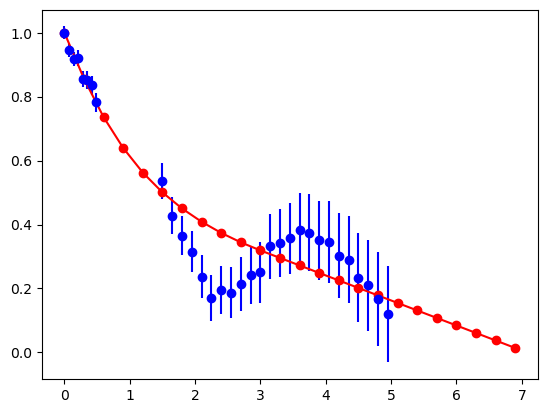

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f59978ac160>

In [67]:
cosmology = Cosmology()
data_1_x = Vector(0:0.07:0.5) 
data_2_x = Vector(1.5:0.15:5)
data_x = zeros(length(data_1_x)+length(data_2_x), 1)
data_x[1:length(data_1_x), 1] = data_1_x
data_x[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = data_2_x
N = length(data_x)

data = similar(vec(data_x))
data[1:length(data_1_x), 1] = cosmology.Dz(vec(data_1_x)) .* (1 .+ randn(length(data_1_x)) .* 0.03)
data[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = cosmology.Dz(vec(data_2_x)) .* (1 .+ 0.5 .* (sin.(vec(data_2_x)./0.5) + randn(length(data_2_x)) * 0.1))
#data = cosmology.Dz(vec(data_x)) .* (1 .+ 0.5 .* (sin.(vec(data_x)./0.5) + randn(N) * 0.1))
data_err = vec(@.((0.02 * data) + (0.03 * vec(data_x))))
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo")
gp_x = Vector(0:0.3:7)
gp_N = length(gp_x)
plt.plot(gp_x, cosmology.Dz(gp_x) .* ones(gp_N), "ro-")

In [68]:
data_cov = zeros(N, N)
for i in 1:N
    data_cov[i,i] = data_err[i]^2 
end

In [102]:
function model_latent_GP(X=data_x, data_cov=data_cov, cov_fn=sqexp_cov_fn)
    Ωm = rand(Uniform(0.1, 0.6))
    Ωb = 0.05 #~ Uniform(0.03, 0.07)
    h = 0.67 #~ Uniform(0.6, 0.9)
    s8 = rand(Uniform(0.6, 1.0))
    ns = 0.96 #~ Uniform(0.87, 1.07)
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, s8, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="linear")
    
    # Dimensions of predictors .
    N, P = size(X)
    gp_x = Vector(0:0.3:7)
    gp_N = length(gp_x)
    Q = N + gp_N
    Z = [X; gp_x]
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), Z, dims=1)
    Dz = cosmology.Dz(vec(X))
    Dz_gp = cosmology.Dz(vec(gp_x))
    
    # Priors.
    mu = rand(Exponential(1))
    phi = rand(Uniform(0.1, 3))
    
    # Set up GP
    K = cov_fn(D, mu, phi)
    Koo = K[(N+1):end, (N+1):end] # GP-GP cov
    Knn = K[1:N, 1:N] + data_cov  # Data-Data cov
    Kno = K[1:N, (N+1):end]       # Data-GP cov
    
    v = rand(MvNormal(zeros(gp_N), 0.3*ones(gp_N)))
    gp = Dz_gp .+ cholesky(Koo).U' * v
    # Conditional 
    Koo_inv = inv(Koo)            
    C = Kno * Koo_inv
    m = C * gp #Dz .+ C * gp
    S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
    y = rand(MvNormal(m, S))
    return mu, phi, v, gp, y
end

model_latent_GP (generic function with 5 methods)

In [103]:
N = 100
mus = zeros(N)
phis= zeros(N)
vs=zeros(N, 24)
gps=zeros(N, 24)
ys=zeros(N, 32)
for i in 1:N
    mus[i], phis[i], vs[i, :], gps[i, :], ys[i, :] = model_latent_GP()
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

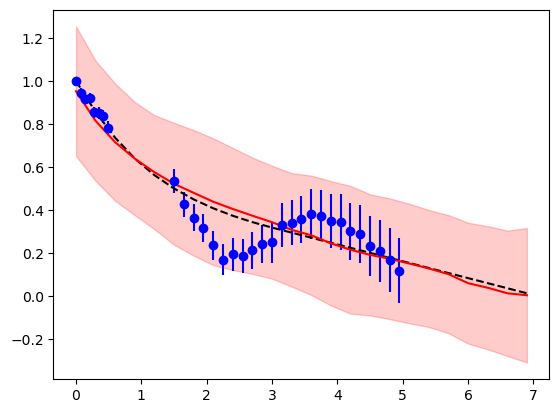

PyObject <matplotlib.collections.PolyCollection object at 0x7f599735da60>

In [104]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(gp_x, cosmology.Dz(gp_x), "k--", label="LCDM")
plt.plot(vec(gp_x), vec(gp_m), "r-")
plt.fill_between(vec(gp_x), vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red")

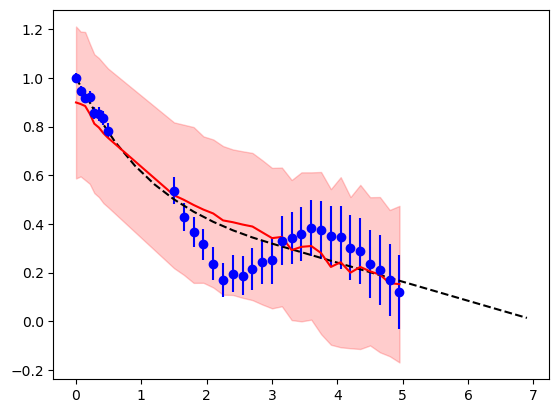

PyObject <matplotlib.collections.PolyCollection object at 0x7f59972ec490>

In [105]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(gp_x, cosmology.Dz(gp_x), "k--", label="LCDM")
plt.plot(vec(data_x), vec(y_m), "r-")
plt.fill_between(vec(data_x), vec(y_m .+ y_s),  vec(y_m .- y_s), alpha=0.2, color="red")

In [106]:
@model function latent_GP(y; X=data_x, data_cov=data_cov, cov_fn=sqexp_cov_fn)
    Ωm = rand(Uniform(0.1, 0.6))
    Ωb = 0.05 #~ Uniform(0.03, 0.07)
    h = 0.67 #~ Uniform(0.6, 0.9)
    s8 = rand(Uniform(0.6, 1.0))
    ns = 0.96 #~ Uniform(0.87, 1.07)
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, s8, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="linear")
    
    # Dimensions of predictors .
    N, P = size(X)
    gp_x = Vector(0:0.3:7)
    gp_N = length(gp_x)
    Q = N + gp_N
    Z = [X; gp_x]
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), Z, dims=1)
    Dz = cosmology.Dz(vec(X))
    Dz_gp = cosmology.Dz(vec(gp_x))
    
    # Priors.
    mu ~ Exponential(0.5)
    phi ~ Uniform(0.1, 3)
    
    # Set up GP
    K = cov_fn(D, abs(mu), phi)
    Koo = K[(N+1):end, (N+1):end] # GP-GP cov
    Knn = K[1:N, 1:N] + data_cov  # Data-Data cov
    Kno = K[1:N, (N+1):end]       # Data-GP cov
    
    v ~ MvNormal(zeros(gp_N), 0.3 .* ones(gp_N))
    gp = Dz_gp .+ cholesky(Koo).U' * v
    # Conditional 
    Koo_inv = inv(Koo)            
    C = Kno * Koo_inv
    m = (Dz .- y) .+ C * gp
    S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
    y ~ MvNormal(m, S)
end

latent_GP (generic function with 1 method)

In [ ]:
chain = sample(latent_GP(data), HMC(0.005, 100), 1000)

Sampling:   2%|▋                                        |  ETA: 2:48:58

In [ ]:
mu = group(chain, :mu).value.data[:, :, 1]
phi = group(chain, :phi).value.data[:, :, 1]
Ωm = group(chain, :Ωm).value.data[:, :, 1]
s8 = group(chain, :s8).value.data[:, :, 1]
v = group(chain, :v).value.data[:, :, 1]

In [ ]:
gp = similar(v)
Z = zeros(length(gp_x), 1)
Z[:, 1] = gp_x
for i in 1:length(v[:,1])
    Ωm = 
    Ωb = 0.05 #~ Uniform(0.03, 0.07)
    h = 0.67 #~ Uniform(0.6, 0.9)
    s8 = rand(Uniform(0.6, 1.0))
    ns = 0.96 #~ Uniform(0.87, 1.07)
    cosmology = LimberJack.Cosmology(Ωm[i], 0.05, 0.67, s8[i], s8,
                                     tk_mode="EisHu",
                                     Pk_mode="linear")
    D = pairwise(Distances.Euclidean(), Z, dims=1)
    Dz = cosmology.Dz(gp_x)
    K = sqexp_cov_fn(D, mu[i], phi[i])
    gp[i,:] = Dz .+ cholesky(K).U' * v[i, :]
end

gp_m = mean(gp, dims=1)
gp_s = std(gp, dims=1)

plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(gp_x, cosmology.Dz(gp_x), "k--", label="LCDM")
plt.plot(vec(gp_x), vec(gp_m), "r-")
plt.fill_between(vec(gp_x), vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red")